#### Outlier detection: number of distinct selections and score
Uses a multivariate outlier detection technique (combined Z-score with a threshold of 3) to identify outliers using these two metrics:
- the average number of distinct selections made by a participant
- the average score of a participant

Creates a new experiment data file with the outliers flagged, the data merged, and updated participant IDs indicating their cohort.

In [2]:
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import statistics
import numpy as np
from math import sqrt
from common import set_matplotlib_latex, plot_colours, set_axes_length
set_matplotlib_latex()

nr_participants = [10, 40, 51]
def get_data_path(number):
    return f"../data/ColourCombo_{number}_anonymised.json"

participants_data = []
for nr in nr_participants:
    data_path = get_data_path(nr)
    with open(data_path) as file:
        all_data = json.load(file)
        for participant_data in all_data:
            participant_data["id"] = str(nr) + ">" + participant_data["id"]
            participants_data.append(participant_data)

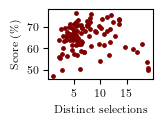

In [3]:
# plot the average number of distinct selections made by a participants against their score
participant_selections = []
participant_scores = []
for participant_data in participants_data:
    selections_per_round = []
    round_scores = []
    for round in participant_data["experimentData"]["roundsData"]:
        if round["roundType"] == "tutorial":
            continue
        selections = []
        for trial in round["trials"]:
            combination = tuple(trial["combination"])
            if combination not in selections:
                selections.append(combination)
        selections_per_round.append(len(set(selections)))
        round_scores.append(round["relativeScore"] * 100)
    participant_selections.append(np.mean(selections_per_round))
    participant_scores.append(np.mean(round_scores))
plot_width = 1.05
plot_height = 0.7
plt.scatter(participant_selections, participant_scores, color=plot_colours["distinctColours"][2], s=6)
set_axes_length(plot_width, plot_height)
plt.gca().xaxis.set_major_locator(MultipleLocator(base=5))
plt.gca().yaxis.set_major_locator(MultipleLocator(base=10))
plt.xlabel("Distinct selections", labelpad=8, verticalalignment="center")
plt.ylabel("Score (\%)")
plt.savefig("../figures/flag_outliers/distinct_selections_vs_score_per_participant.pdf", bbox_inches='tight')
plt.show()

In [4]:
# find the outliers of the [participant_selections, participant_scores] array using combined Z-scores
mean_selections = statistics.mean(participant_selections)
std_selections = statistics.stdev(participant_selections)
mean_scores = statistics.mean(participant_scores)
std_scores = statistics.stdev(participant_scores)
z_scores = []
for i in range(len(participant_selections)):
    z_score = sqrt((participant_selections[i] - mean_selections) ** 2 / std_selections ** 2 + (participant_scores[i] - mean_scores) ** 2 / std_scores ** 2)
    z_scores.append(z_score)
outliers = []
for i in range(len(z_scores)):
    if z_scores[i] > 3:
        outliers.append({"participant": participants_data[i]["id"], "z_score": z_scores[i], "group": participants_data[i]["experimentData"]["recommendationType"]})
for outlier in outliers:
    print(f"Participant cohort and ID: {outlier['participant']},    Z-score: {outlier['z_score']},    Group: {outlier['group']}")

Participant cohort and ID: 10>5,    Z-score: 3.2346059912700973,    Group: low
Participant cohort and ID: 40>17,    Z-score: 3.7952474278071473,    Group: low
Participant cohort and ID: 40>25,    Z-score: 3.3612387029731545,    Group: low
Participant cohort and ID: 51>36,    Z-score: 3.6808843120474517,    Group: high


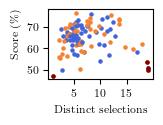

In [5]:
# replot the data with the outliers flagged, shown with a different colour,
# and local and global conditions shown with their colours
plot_width = 1.05
plot_height = 0.7

for participant_data, selections, scores, in zip(participants_data, participant_selections, participant_scores):
    if participant_data["experimentData"]["recommendationType"] == "high":
        plt.scatter(selections, scores, color=plot_colours["global"], s=5, label="Global")
    else:
        plt.scatter(selections, scores, color=plot_colours["local"], s=5, label="Local")
for outlier in outliers:
    index = [participant_data["id"] for participant_data in participants_data].index(outlier["participant"])
    plt.scatter(participant_selections[index], participant_scores[index], color=plot_colours["distinctColours"][2], s=5, label="Excluded")

plt.gca().xaxis.set_major_locator(MultipleLocator(base=5))
plt.gca().yaxis.set_major_locator(MultipleLocator(base=10))
plt.xlabel("Distinct selections", labelpad=8, verticalalignment="center")
plt.ylabel("Score (\%)", loc="top")
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
set_axes_length(plot_width, plot_height)
plt.savefig("../figures/flag_outliers/selections_vs_score_per_participant_flagged.pdf", bbox_inches='tight')
plt.show()

In [6]:
# create a new experiment file with the outliers flagged
outliers_ids = [outlier["participant"] for outlier in outliers]
for participant_data in participants_data:
    if participant_data["id"] in outliers_ids:
        participant_data["outlier"] = True
    else:
        participant_data["outlier"] = False
with open("../data/ColourCombo_101_flagged.json", "w") as file:
    json.dump(participants_data, file)